In [38]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

In [39]:
df = pd.read_csv("../data/EURUSD_with_signals_with_clusters.csv")

with open("../data/selected_combos.json") as f:
    selected_combos = json.load(f)

In [40]:
all_features = sorted(list({feat for features in selected_combos.values() for feat in features}))

In [41]:
df = df[all_features + ["signal"]].dropna()

In [42]:
def simplify_label(label):
    if "Buy" in label:
        return "Buy"
    elif "Sell" in label:
        return "Sell"
    else:
        return "Hold"

df["signal"] = df["signal"].astype(str).apply(simplify_label)

In [43]:
X = df[all_features]
y = df["signal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [45]:
sample_weights = y_train.map(class_weights)

In [46]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights)

GradientBoostingClassifier(random_state=42)

In [47]:
y_pred = model.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")


📊 Classification Report:
              precision    recall  f1-score   support

         Buy       0.63      0.61      0.62       225
        Hold       0.00      0.00      0.00         0
        Sell       0.62      0.64      0.63       227

    accuracy                           0.63       452
   macro avg       0.42      0.42      0.42       452
weighted avg       0.63      0.63      0.63       452


✅ Accuracy: 0.6261


/opt/anaconda3/envs/dpenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dpenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/dpenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


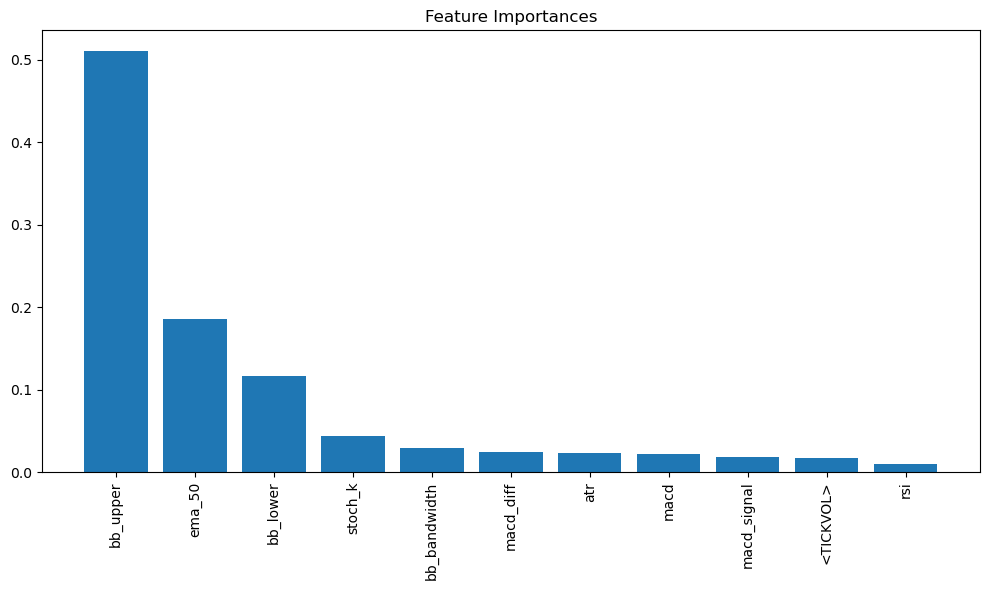

['../models/gradient_boosting_trading_model.pkl']

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(all_features)), importances[indices], align="center")
plt.xticks(range(len(all_features)), [all_features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

joblib.dump(model, "../models/gradient_boosting_trading_model.pkl")

In [49]:
feature_importance_dict = {all_features[i]: float(importances[i]) for i in range(len(all_features))}
with open("../data/feature_importances.json", "w") as f:
    json.dump(feature_importance_dict, f, indent=4)